# Benchmarking

In [1]:
import sys
import time
import os
import pandas as pd
import numpy as np
from functools import partial
# sys.path.append('/Users/calum/Developer/pyzx-heuristics-master')
# import pyzx as zx_heuristics
sys.path.append('..')
import pyzx as zx
from benchmarking import benchmark

In [2]:
# b = benchmark(dirpath='benchmark')
b = benchmark()
b.load_circuits(os.path.join('..', 'circuits', 'benchmarking', 'Fast', 'before'), group_name='fast')
b.load_circuits(os.path.join('..', 'circuits', 'benchmarking', 'Fast', 'nrscm'), group_name='fast', simp_strategy='NRSCM')
b.show_attributes()

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_simp', 't_opt']
No loaded functions
Loaded routines:  ['NRSCM']
Loaded circuit groups:  ['fast']


,Original,NRSCM
fast,Y,Y


In [3]:

def basic(c):
    c1 = zx.optimize.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.optimize.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2
    return c1

def full_reduce(c):
    g = c.to_graph()
    zx.simplify.full_reduce(g,quiet=True)
    c2 = zx.extract_circuit(g,up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

def int_cliff(c):
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce_3(g,x=None, quiet=True)
    c2 = zx.extract.extract_circuit(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

def int_cliff_lim(c):
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce_2(g,x=None, flow='g',quiet=True)
    c2 = zx.extract.extract_circuit(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

def int_cliff_lim(c):
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce_2(g,x=None, flow='g',quiet=True)
    c2 = zx.extract.extract_circuit(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

def int_cliff_lim_flow(c):
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce_2(g,x=None, flow='causal',quiet=True)
    c2 = zx.extract.extract_simple(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

def nu_flow(c):
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce(g,x=None, flow='causal',quiet=True)
    c2 = zx.extract.extract_simple(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

def nu(c):
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce(g,x=None, flow='g',quiet=True)
    c2 = zx.extract.extract_circuit(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

In [4]:
b.add_simplification_func(basic, 'Basic', groups_to_run=[],verify=False)
b.add_simplification_func(full_reduce, 'full_reduce', groups_to_run=[],verify=False)
b.add_simplification_func(int_cliff, 'int_cliff', groups_to_run=[],verify=False)
b.add_simplification_func(int_cliff_lim, 'int_cliff_lim', groups_to_run=[],verify=False)
b.add_simplification_func(int_cliff_lim_flow, 'int_cliff_lim_flow', groups_to_run=[],verify=False)
b.add_simplification_func(nu_flow, 'nu_flow', groups_to_run=[],verify=False)
b.add_simplification_func(nu, 'nu', groups_to_run=[],verify=False)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [7]:
b.add_simplification_func(basic, 'Basic', groups_to_run=['fast'],verify=False)
b.add_simplification_func(full_reduce, 'full_reduce', groups_to_run=['fast'],verify=False)
b.add_simplification_func(int_cliff, 'int_cliff', groups_to_run=['fast'],verify=False)
b.add_simplification_func(int_cliff_lim, 'int_cliff_lim', groups_to_run=['fast'],verify=False)
b.add_simplification_func(int_cliff_lim_flow, 'int_cliff_lim_flow', groups_to_run=['fast'],verify=False)
b.add_simplification_func(nu_flow, 'nu_flow', groups_to_run=['fast'],verify=False)
b.add_simplification_func(nu, 'nu', groups_to_run=['fast'],verify=False)


100%|██████████| 32/32 [00:00<00:00, 741534.41it/s]
Processing nu on adder_8                                              :  75%|███████▌  | 24/32 [22:54<07:38, 57.26s/it] 


KeyboardInterrupt: 

In [5]:
b.show_attributes()

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_simp', 't_opt']
Loaded functions:  ['Basic', 'full_reduce', 'int_cliff', 'int_cliff_lim', 'int_cliff_lim_flow', 'nu_flow']
Loaded routines:  ['NRSCM']
Loaded circuit groups:  ['fast']


,Original,Basic,NRSCM,full_reduce,int_cliff,int_cliff_lim,int_cliff_lim_flow,nu_flow
fast,Y,Y,Y,Y,Y,Y,Y,Y


In [8]:
df = b.df(groups=['fast'],
     routines='all',
     funcs='all',
     atts=['Qubits', '2Q Count','T Count'])

Processing nu_flow on P_t = 0.285                 : 100%|██████████| 20/20 [19:14<00:00, 57.73s/it]        


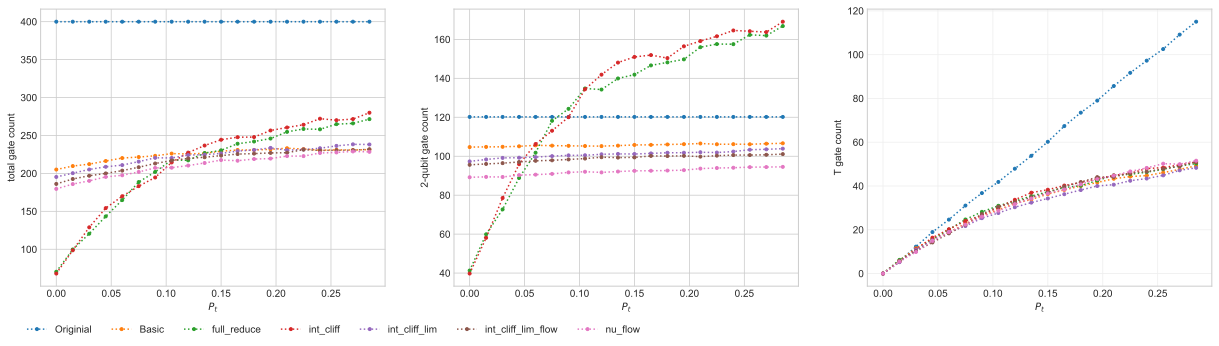

In [7]:
funcs = ['Basic', 'full_reduce', 'int_cliff', 'int_cliff_lim', 'int_cliff_lim_flow', 'nu_flow']
t_probs = [0.05*i for i in range(6)]
fig = b.Pt_graphs(funcs=funcs, qubits=8, depth=400, cnot_prob=0.3, t_probs=t_probs, ys=['Gates','2Q Count','T Count'], reps=20, overwrite=True, random_seed=42)

In [13]:
b.save(dirpath='benchmark')